## 1. Import Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import nltk
#nltk.download()
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble, metrics, model_selection, naive_bayes
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
from nltk.tag import pos_tag
import string
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [5]:
import os

#mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
#mingw_path =  'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
#os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
os.environ['PATH'] = os.environ['PATH'] + ';C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

In [6]:
import xgboost as xgb

In [7]:
from xgboost.sklearn import XGBClassifier

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV 

C:\Users\Tushu\nlp\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tushu\nlp\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [9]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

In [140]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.2
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [11]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [12]:
def runSVM(train_X, train_y, test_X, test_y, test_X2):
    model = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, random_state=42,max_iter=10, tol=None)
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

## 2. Load Files

In [13]:
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
print(train.head(10))
print(train.shape)
print('='*90)
print(test.head(10))
print(test.shape)

        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL
5  id22965  A youth passed in solitude, my best years spen...    MWS
6  id09674  The astronomer, perhaps, at this point, took r...    EAP
7  id13515        The surcingle hung in ribands from my body.    EAP
8  id19322  I knew that you could not say to yourself 'ste...    EAP
9  id00912  I confess that neither the structure of langua...    MWS
(19579, 3)
        id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2  id00134  And when they had broken down th

In [14]:
print(train.author.describe())
print('='*90)
print(train.id.describe())

count     19579
unique        3
top         EAP
freq       7900
Name: author, dtype: object
count       19579
unique      19579
top       id17087
freq            1
Name: id, dtype: object


In [15]:
full_data=train.loc[:,['id','text']].append(test, ignore_index = True).copy()
assert full_data.shape==(27971,2)

## 3. NLP

## 3.a Counting word features


In [16]:
#full_data['text_tokenized'] =full_data.apply(lambda row: nltk.word_tokenize(row['text']),axis=1) 
word_features=full_data.copy()

In [17]:
## Number of words in the text ##
word_features["num_words"] = word_features["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
word_features["num_unique_words"] = word_features["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
word_features["num_chars"] = word_features["text"].apply(lambda x: len(str(x)))


## Number of stopwords in the text ##
word_features["num_stopwords"] = word_features["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
word_features["num_punctuations"] = word_features['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
word_features["num_words_upper"] = word_features["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
word_features["num_words_title"] = word_features["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

assert word_features.shape==(27971,9)

In [18]:
word_features=word_features.reset_index(drop=True)
cols_to_drop_word_feat = ['id','text']
word_features=word_features.drop(cols_to_drop_word_feat, axis=1).reset_index(drop=True)
word_features=(word_features-word_features.mean())/word_features.std()
word_features.head()



,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title
0,0.747282,0.883341,0.764710,0.605677,1.093223,1.411018,0.428156
1,-0.659261,-0.673125,-0.721406,-0.511273,-0.916562,-0.601402,-0.598413
2,0.486811,0.660989,0.476775,0.301054,0.423295,-0.601402,-0.598413
3,0.382623,0.660989,0.532505,-0.003569,0.088331,-0.601402,0.941441
4,0.017963,0.142167,0.235282,-0.206650,0.088331,-0.601402,-0.085128


In [19]:
word_features_train_df=word_features[:19579].copy()
word_features_test_df=word_features[19579:].copy()

In [20]:
cleaned_full_df=full_data.copy()

##  3.b Tokenization


In [21]:
tokenizer = RegexpTokenizer(r'\w+')
cleaned_full_df['text_tokenized'] =cleaned_full_df.apply(lambda row: tokenizer.tokenize(row['text']),axis=1) 

## 3.c Remove Stopwords

In [22]:
stopwords = nltk.corpus.stopwords.words('english')

In [23]:
cleaned_full_df['text_stopwords_removed']=cleaned_full_df['text_tokenized'].apply(lambda row: ([word for word in row if word.lower() not in (stopwords)])) 

In [24]:
cleaned_full_df.head()

,id,text,text_tokenized,text_stopwords_removed
0,id26305,"This process, however, afforded me no means of...","[This, process, however, afforded, me, no, mea...","[process, however, afforded, means, ascertaini..."
1,id17569,It never once occurred to me that the fumbling...,"[It, never, once, occurred, to, me, that, the,...","[never, occurred, fumbling, might, mere, mistake]"
2,id11008,"In his left hand was a gold snuff box, from wh...","[In, his, left, hand, was, a, gold, snuff, box...","[left, hand, gold, snuff, box, capered, hill, ..."
3,id27763,How lovely is spring As we looked from Windsor...,"[How, lovely, is, spring, As, we, looked, from...","[lovely, spring, looked, Windsor, Terrace, six..."
4,id12958,"Finding nothing else, not even gold, the Super...","[Finding, nothing, else, not, even, gold, the,...","[Finding, nothing, else, even, gold, Superinte..."


## 3.d Stemming And Lemmatization


In [25]:
stemmer = PorterStemmer()
cleaned_full_df['stemming_lemmatizaion']=cleaned_full_df['text_stopwords_removed'].apply(lambda row: ([stemmer.stem(word) for word in row]))
cleaned_full_df.head()

,id,text,text_tokenized,text_stopwords_removed,stemming_lemmatizaion
0,id26305,"This process, however, afforded me no means of...","[This, process, however, afforded, me, no, mea...","[process, however, afforded, means, ascertaini...","[process, howev, afford, mean, ascertain, dime..."
1,id17569,It never once occurred to me that the fumbling...,"[It, never, once, occurred, to, me, that, the,...","[never, occurred, fumbling, might, mere, mistake]","[never, occur, fumbl, might, mere, mistak]"
2,id11008,"In his left hand was a gold snuff box, from wh...","[In, his, left, hand, was, a, gold, snuff, box...","[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, snuff, box, caper, hill, cu..."
3,id27763,How lovely is spring As we looked from Windsor...,"[How, lovely, is, spring, As, we, looked, from...","[lovely, spring, looked, Windsor, Terrace, six...","[love, spring, look, windsor, terrac, sixteen,..."
4,id12958,"Finding nothing else, not even gold, the Super...","[Finding, nothing, else, not, even, gold, the,...","[Finding, nothing, else, even, gold, Superinte...","[find, noth, els, even, gold, superintend, aba..."


In [26]:
Lemmatizer = WordNetLemmatizer()
cleaned_full_df['stemming_lemmatizaion']=cleaned_full_df['stemming_lemmatizaion'].apply(lambda row: ([Lemmatizer.lemmatize(word) for word in row]))
cleaned_full_df.head()


,id,text,text_tokenized,text_stopwords_removed,stemming_lemmatizaion
0,id26305,"This process, however, afforded me no means of...","[This, process, however, afforded, me, no, mea...","[process, however, afforded, means, ascertaini...","[process, howev, afford, mean, ascertain, dime..."
1,id17569,It never once occurred to me that the fumbling...,"[It, never, once, occurred, to, me, that, the,...","[never, occurred, fumbling, might, mere, mistake]","[never, occur, fumbl, might, mere, mistak]"
2,id11008,"In his left hand was a gold snuff box, from wh...","[In, his, left, hand, was, a, gold, snuff, box...","[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, snuff, box, caper, hill, cu..."
3,id27763,How lovely is spring As we looked from Windsor...,"[How, lovely, is, spring, As, we, looked, from...","[lovely, spring, looked, Windsor, Terrace, six...","[love, spring, look, windsor, terrac, sixteen,..."
4,id12958,"Finding nothing else, not even gold, the Super...","[Finding, nothing, else, not, even, gold, the,...","[Finding, nothing, else, even, gold, Superinte...","[find, noth, el, even, gold, superintend, aban..."


In [27]:
assert(cleaned_full_df.shape==(27971,5))

## 3.d Counting grammer

In [28]:
grammer_type_df= cleaned_full_df["text_tokenized"].apply(lambda x: nltk.pos_tag(x))

In [29]:
grammer_type_df


0        [(This, DT), (process, NN), (however, RB), (af...
1        [(It, PRP), (never, RB), (once, RB), (occurred...
2        [(In, IN), (his, PRP$), (left, JJ), (hand, NN)...
3        [(How, WRB), (lovely, RB), (is, VBZ), (spring,...
4        [(Finding, VBG), (nothing, NN), (else, RB), (n...
5        [(A, DT), (youth, NN), (passed, VBN), (in, IN)...
6        [(The, DT), (astronomer, NN), (perhaps, RB), (...
7        [(The, DT), (surcingle, NN), (hung, NN), (in, ...
8        [(I, PRP), (knew, VBD), (that, IN), (you, PRP)...
9        [(I, PRP), (confess, VBP), (that, IN), (neithe...
10       [(He, PRP), (shall, MD), (find, VB), (that, IN...
11       [(Here, RB), (we, PRP), (barricaded, VBD), (ou...
12       [(Herbert, NNP), (West, NNP), (needed, VBD), (...
13       [(The, DT), (farm, NN), (like, IN), (grounds, ...
14       [(But, CC), (a, DT), (glance, NN), (will, MD),...
15       [(He, PRP), (had, VBD), (escaped, VBN), (me, P...
16       [(To, TO), (these, DT), (speeches, NNS), (they.

In [30]:
count_grammer_types= grammer_type_df.apply(lambda x: Counter(tag for word,tag in x))


In [31]:
count_grammer_types

0        {'VBP': 1, 'VB': 1, 'DT': 6, 'RB': 3, 'RP': 1,...
1        {'VB': 1, 'JJ': 1, 'MD': 1, 'VBD': 1, 'PRP': 2...
2        {'DT': 5, 'PRP': 2, 'RP': 1, 'VBG': 1, 'RB': 1...
3        {'VBN': 1, 'NN': 4, 'DT': 2, 'RB': 1, 'PRP': 1...
4        {'VB': 1, 'DT': 2, 'RB': 4, 'CC': 1, 'VBG': 2,...
5        {'VBP': 3, 'VB': 3, 'DT': 6, 'RB': 4, 'CC': 4,...
6        {'JJ': 2, 'VB': 1, 'VBD': 2, 'RB': 3, 'CC': 1,...
7         {'NNS': 1, 'NN': 3, 'DT': 1, 'PRP$': 1, 'IN': 2}
8        {'VB': 5, 'DT': 6, 'RB': 12, 'CC': 3, 'TO': 4,...
9        {'JJ': 1, 'DT': 3, 'PRP': 2, 'VBD': 1, 'NNS': ...
10       {'JJ': 1, 'TO': 1, 'VB': 4, 'NNP': 1, 'PRP': 4...
11       {'JJ': 1, 'NN': 1, 'VBD': 2, 'RB': 1, 'NNS': 1...
12       {'JJ': 2, 'VBD': 2, 'NNS': 1, 'DT': 2, 'NNP': ...
13       {'TO': 1, 'VBN': 1, 'RB': 4, 'NNS': 1, 'DT': 2...
14       {'MD': 1, 'DT': 3, 'VB': 1, 'CC': 1, 'NN': 3, ...
15       {'VB': 4, 'DT': 6, 'PRP': 4, 'CC': 4, 'MD': 3,...
16       {'VB': 1, 'DT': 6, 'PRP': 7, 'CC': 3, 'MD': 1,.

In [32]:
count_grammer_df = pd.DataFrame.from_records(count_grammer_types)
count_grammer_df.head()

,'',CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,NaN,1.0,NaN,6.0,NaN,NaN,5.0,2.0,NaN,NaN,...,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,5.0,NaN,NaN,6.0,4.0,NaN,1.0,...,NaN,3.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,NaN,2.0,NaN,2.0,NaN,NaN,6.0,5.0,1.0,NaN,...,NaN,2.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0
4,NaN,1.0,NaN,2.0,NaN,NaN,3.0,1.0,NaN,NaN,...,1.0,1.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN


In [33]:
count_grammer_df.isnull().sum().sort_values(ascending=True)

NN       1705
IN       2595
DT       2995
JJ       6251
VBD      6347
PRP      6630
RB       8467
CC       9249
NNS     11316
VB      13660
VBN     14049
PRP$    14625
TO      15671
NNP     18087
VBG     19632
MD      20783
VBP     20851
VBZ     22331
WDT     22655
WRB     24666
CD      24815
WP      25102
RP      25672
JJR     26224
JJS     26470
EX      26488
RBR     26653
PDT     27027
RBS     27375
WP$     27450
FW      27755
NNPS    27835
UH      27853
POS     27964
''      27969
dtype: int64

In [34]:
grammer_nan_df=count_grammer_df.loc[:,['NN','IN','DT','JJ','VBD','PRP','RB','CC','VBP','TO','WRB']]
#grammer_nan_df=count_grammer_df.loc[:,:]
grammer_df=grammer_nan_df.fillna(0).copy()
print(grammer_df.shape)
grammer_df.head(5)

grammer_df=(grammer_df-grammer_df.mean())/grammer_df.std()
#train_data=full_data[:19579]
grammer_train_df=grammer_df[:19579].copy()
grammer_test_df=grammer_df[19579:].copy()
print('train',grammer_train_df.shape)
print('test',grammer_test_df.shape)


#count the character in each 
grammer_nan_train_df=grammer_nan_df[:19579].copy()
grammer_nan_test_df=grammer_nan_df[19579:].copy()

#CC: conjunction, coordinating
#DT: determiner
#IN: preposition or conjunction, subordinating
#NN: noun, common, singular or mass
#JJ: adjective or numeral, ordinal
#VBD: verb, past tense
#PRP: pronoun, personal
#RB: adverb
grammer_train_df.head()

(27971, 11)
train (19579, 11)
test (8392, 11)


,NN,IN,DT,JJ,VBD,PRP,RB,CC,VBP,TO,WRB
0,1.00305,0.403782,1.106331,-0.01117,0.152349,0.663874,0.971352,-0.155297,0.742582,0.364126,-0.335139
1,-0.63303,-0.815465,-0.381615,-0.49111,-0.466045,0.131286,0.338896,-0.923840,-0.451483,0.364126,-0.335139
2,1.27573,0.708594,0.734345,0.94871,0.770742,0.131286,-0.293561,-0.923840,-0.451483,-0.673145,-0.335139
3,-0.08767,0.708594,-0.381615,1.42865,0.152349,-0.401302,-0.293561,0.613246,0.742582,-0.673145,2.109235
4,0.18501,-0.205841,-0.381615,-0.49111,-0.466045,-0.401302,1.603809,-0.155297,-0.451483,-0.673145,-0.335139


In [35]:
grammer_nan_auth_df=pd.concat([grammer_nan_train_df,train['author']], axis=1).copy()
grammer_nan_auth_df.head()

,NN,IN,DT,JJ,VBD,PRP,RB,CC,VBP,TO,WRB,author
0,8.0,5.0,6.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,NaN,EAP
1,2.0,1.0,2.0,1.0,1.0,2.0,2.0,NaN,NaN,1.0,NaN,HPL
2,9.0,6.0,5.0,4.0,3.0,2.0,1.0,NaN,NaN,NaN,NaN,EAP
3,4.0,6.0,2.0,5.0,2.0,1.0,1.0,2.0,1.0,NaN,1.0,MWS
4,5.0,3.0,2.0,1.0,1.0,1.0,4.0,1.0,NaN,NaN,NaN,HPL


In [37]:
grammer_auth_df=pd.concat([grammer_df,train['author']], axis=1).copy()
grammer_auth_df.head()
assert (grammer_auth_df.shape == (27971,12))



In [38]:
grammer_grouped_train_df=grammer_auth_df.groupby(['author']).agg({'NN':sum,'IN':sum,'DT':sum,'JJ':sum,'VBD':sum,'PRP':sum,'RB':sum,'CC':sum}).reset_index()

In [39]:
grammer_grouped_train_df

,author,JJ,DT,PRP,CC,VBD,NN,RB,IN
0,EAP,-535.068683,604.670528,-951.526498,-1223.770309,-1925.514897,-221.945491,466.842257,146.333507
1,HPL,1034.679173,309.174440,-611.913345,727.315194,1131.815494,211.676626,294.384586,172.720879
2,MWS,-510.017372,-825.602997,1554.560236,467.820309,777.329012,128.646064,-730.094235,-238.531408


In [40]:
#grammer_grouped_count_train_df=grammer_nan_auth_df.groupby(['author']).agg({'NN':'count','IN':'count','DT':'count','JJ':'count','VBD':'count','PRP':'count','RB':'count','CC':'count'}).reset_index()
grammer_grouped_count_train_df=grammer_nan_auth_df.groupby(['author']).agg('count').reset_index()
pd.set_option('display.max_columns', 36)
grammer_grouped_count_train_df

,author,NN,IN,DT,JJ,VBD,PRP,RB,CC,VBP,TO,WRB
0,EAP,7356,6985,7062,5857,5448,5703,5483,4621,2060,3245,700
1,HPL,5353,5256,5232,4785,4941,4210,4221,4205,1232,2418,802
2,MWS,5672,5480,5234,4574,4789,5012,3912,4240,1637,3002,827


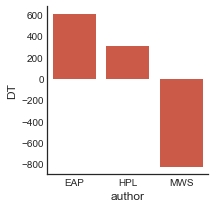

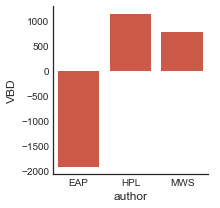

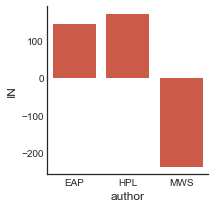

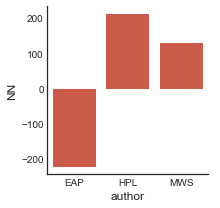

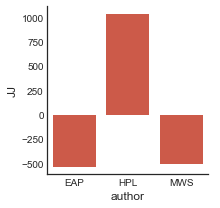

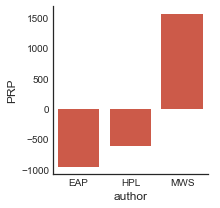

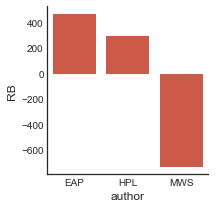

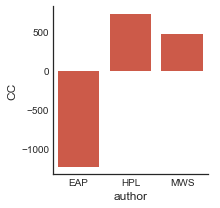

In [41]:
ax=plot_categories(grammer_grouped_train_df,cat='author',target='DT')
ax=plot_categories(grammer_grouped_train_df,cat='author',target='VBD')
ax=plot_categories(grammer_grouped_train_df,cat='author',target='IN')
ax=plot_categories(grammer_grouped_train_df,cat='author',target='NN')
ax=plot_categories(grammer_grouped_train_df,cat='author',target='JJ')
ax=plot_categories(grammer_grouped_train_df,cat='author',target='PRP')
ax=plot_categories(grammer_grouped_train_df,cat='author',target='RB')
ax=plot_categories(grammer_grouped_train_df,cat='author',target='CC')
  


## 4.a Creating  TFIDF vector


In [42]:

full_tfidf_df=cleaned_full_df[['id','stemming_lemmatizaion']].copy()
full_tfidf_df['cleaned_data']=full_tfidf_df['stemming_lemmatizaion'].apply(lambda row: ' '.join(row)).copy()
full_tfidf_df=full_tfidf_df.drop(['stemming_lemmatizaion'], axis=1)
full_tfidf_df.head()

,id,cleaned_data
0,id26305,process howev afford mean ascertain dimens dun...
1,id17569,never occur fumbl might mere mistak
2,id11008,left hand gold snuff box caper hill cut manner...
3,id27763,love spring look windsor terrac sixteen fertil...
4,id12958,find noth el even gold superintend abandon att...


In [43]:
train_tfidf_df=full_tfidf_df[:19579].copy()
print(train_tfidf_df.shape)
print('='*90)
test_tfidf_df=full_tfidf_df[19579:].copy()
print(test_tfidf_df.shape)
print('='*90)
assert (train_tfidf_df.shape == (19579, 2))
assert (test_tfidf_df.shape ==(8392, 2))

(19579, 2)
(8392, 2)


In [44]:
tfidf_vec = TfidfVectorizer( ngram_range=(1,5))
v = TfidfVectorizer()

In [45]:
full_tfidf = v.fit_transform(full_tfidf_df['cleaned_data'].values.tolist())
train_tfidf=v.transform(train_tfidf_df['cleaned_data'].values.tolist())
test_tfidf=v.transform(test_tfidf_df['cleaned_data'].values.tolist())
print('full_tfidf',full_tfidf.shape,'train_tfidf',train_tfidf.shape,'test_tfidf',test_tfidf.shape)



full_tfidf (27971, 17153) train_tfidf (19579, 17153) test_tfidf (8392, 17153)


## 4.b Transform TFIDF to SVD vector


In [46]:
n_comp = 25
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf)).copy()
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf)).copy()

print(train_svd.shape)
print('='*90)
print(test_svd.shape)

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]    

(19579, 25)
(8392, 25)


## 5. Applying Model

In [62]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train['author'].map(author_mapping_dict)
train_y.head(10)
train_id = train['id'].values
test_id = test['id'].values


In [48]:
cols_to_drop = ['id', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)

In [49]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.591347495275


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

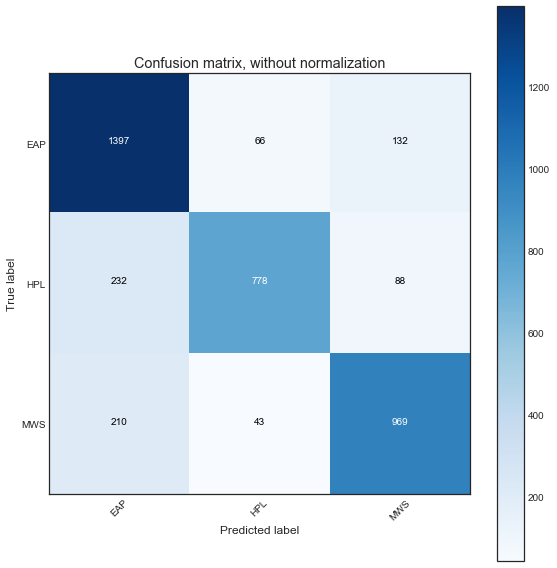

In [51]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

## 6.Creating count TFIDF



In [52]:
# train_data_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
# test_data_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
# new_train = pd.concat([train, train_data_svd], axis=1)
# new_test = pd.concat([test, test_data_svd], axis=1)


In [53]:
full_tfidf_uncleaned_df=cleaned_full_df[['id','text_tokenized']].copy()
full_tfidf_uncleaned_df['uncleaned_data']=full_tfidf_uncleaned_df['text_tokenized'].apply(lambda row: ' '.join(row)).copy()
full_tfidf_uncleaned_df=full_tfidf_uncleaned_df.drop(['text_tokenized'], axis=1)
full_tfidf_uncleaned_df.head()

,id,uncleaned_data
0,id26305,This process however afforded me no means of a...
1,id17569,It never once occurred to me that the fumbling...
2,id11008,In his left hand was a gold snuff box from whi...
3,id27763,How lovely is spring As we looked from Windsor...
4,id12958,Finding nothing else not even gold the Superin...


In [54]:
train_tfidf_uncleaned_df=full_tfidf_uncleaned_df[:19579].copy()
print(train_tfidf_uncleaned_df.shape)
print('='*90)
test_tfidf_uncleaned_df=full_tfidf_uncleaned_df[19579:].copy()
print(test_tfidf_uncleaned_df.shape)
print('='*90)
assert (train_tfidf_uncleaned_df.shape == (19579, 2))
assert (test_tfidf_uncleaned_df.shape ==(8392, 2))

(19579, 2)
(8392, 2)


In [56]:
vc = CountVectorizer(stop_words='english',ngram_range=(1,5))
full_tfidf_uncleaned_count = vc.fit_transform(full_tfidf_uncleaned_df['uncleaned_data'].values.tolist())
train_tfidf_uncleaned_count=vc.transform(train_tfidf_uncleaned_df['uncleaned_data'].values.tolist())
test_tfidf_uncleaned_count=vc.transform(test_tfidf_uncleaned_df['uncleaned_data'].values.tolist())
print('full_tfidf',full_tfidf_uncleaned_count.shape,'train_tfidf',train_tfidf_uncleaned_count.shape,'test tfidf',test_tfidf_uncleaned_count.shape)

full_tfidf (27971, 999220) train_tfidf (19579, 999220) test tfidf (8392, 999220)


In [57]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf_uncleaned_count[dev_index], full_tfidf_uncleaned_count[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf_uncleaned_count)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.454118122959


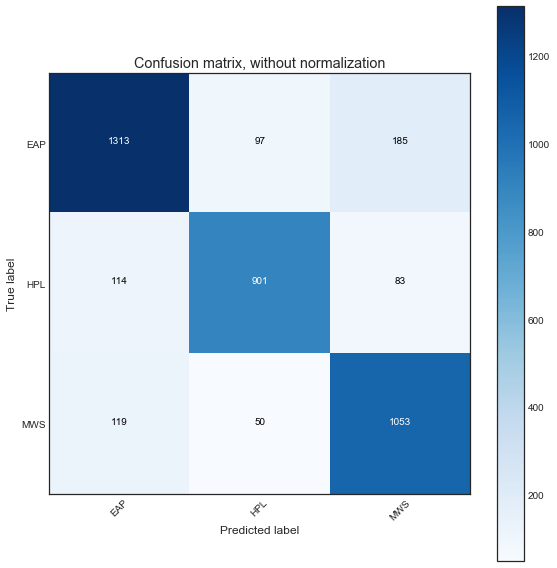

In [58]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

In [59]:
#full_tfidf_uncleaned_count_ftype=full_tfidf_uncleaned_count_ftype.asfptype().copy()
#train_tfidf_uncleaned_count_ftype=train_tfidf_uncleaned_count.asfptype()
#test_tfidf_uncleaned_count_ftype=test_tfidf_uncleaned_count.asfptype()
#https://stackoverflow.com/questions/8650014/sparse-matrix-valueerror-matrix-type-must-be-f-d-f-or-d
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf_uncleaned_count.asfptype())
# train_count_svd = pd.DataFrame(svd_obj.transform(train_tfidf_uncleaned_count.asfptype())).copy()
# test_count_svd = pd.DataFrame(svd_obj.transform(test_tfidf_uncleaned_count.asfptype())).copy()
train_count_svd = pd.DataFrame(svd_obj.transform(train_tfidf_uncleaned_count)).copy()
test_count_svd = pd.DataFrame(svd_obj.transform(test_tfidf_uncleaned_count)).copy()

In [60]:
print(train_count_svd.shape)
print('='*90)
print(test_count_svd.shape)

train_count_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_count_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]

(19579, 20)
(8392, 20)


### XGbost on tfidfcount svd vetor

In [63]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_count_svd.loc[dev_index], train_count_svd.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_count_svd, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.05428	test-mlogloss:1.05974
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.823873	test-mlogloss:0.900474
[40]	train-mlogloss:0.757703	test-mlogloss:0.882349
[60]	train-mlogloss:0.711494	test-mlogloss:0.87568
[80]	train-mlogloss:0.671521	test-mlogloss:0.875405
[100]	train-mlogloss:0.637116	test-mlogloss:0.87332
[120]	train-mlogloss:0.606258	test-mlogloss:0.873374
[140]	train-mlogloss:0.576925	test-mlogloss:0.873206
[160]	train-mlogloss:0.548425	test-mlogloss:0.87512
[180]	train-mlogloss:0.522437	test-mlogloss:0.876721
Stopping. Best iteration:
[134]	train-mlogloss:0.585606	test-mlogloss:0.872152

cv scores :  [0.87215153944861257]


### XGbost on tfidf svd vetor

In [64]:
n_comp = 35
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf)).copy()
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf)).copy()

print(train_svd.shape)
print('='*90)
print(test_svd.shape)

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]    

(19579, 35)
(8392, 35)


In [65]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_svd.loc[dev_index], train_svd.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_svd, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.03606	test-mlogloss:1.04321
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.727223	test-mlogloss:0.808322
[40]	train-mlogloss:0.643242	test-mlogloss:0.782019
[60]	train-mlogloss:0.588645	test-mlogloss:0.77495
[80]	train-mlogloss:0.542289	test-mlogloss:0.771309
[100]	train-mlogloss:0.502836	test-mlogloss:0.76774
[120]	train-mlogloss:0.466576	test-mlogloss:0.764491
[140]	train-mlogloss:0.435778	test-mlogloss:0.765536
[160]	train-mlogloss:0.404791	test-mlogloss:0.76519
Stopping. Best iteration:
[123]	train-mlogloss:0.461456	test-mlogloss:0.764062

cv scores :  [0.76406227882506295]



# Merging Data


In [66]:
#cols_to_drop = ['CC','VBD']
cols_to_drop = []
grammer_test_df=grammer_test_df.reset_index(drop=True)

grammer_train_selected_df = grammer_train_df.drop(cols_to_drop, axis=1).reset_index(drop=True)
grammer_test_selected_df = grammer_test_df.drop(cols_to_drop, axis=1).reset_index(drop=True)

#grammer_train_selected_df=(grammer_train_selected_df-grammer_train_selected_df.mean())/grammer_train_selected_df.std()
#grammer_test_selected_df=(grammer_test_selected_df-grammer_test_selected_df.mean())/grammer_test_selected_df.std()
grammer_train_selected_df.head()
#CC: conjunction, coordinating
#DT: determiner
#IN: preposition or conjunction, subordinating
#NN: noun, common, singular or mass
#JJ: adjective or numeral, ordinal
#VBD: verb, past tense
#PRP: pronoun, personal
#RB: adverb

,NN,IN,DT,JJ,VBD,PRP,RB,CC,VBP,TO,WRB
0,1.00305,0.403782,1.106331,-0.01117,0.152349,0.663874,0.971352,-0.155297,0.742582,0.364126,-0.335139
1,-0.63303,-0.815465,-0.381615,-0.49111,-0.466045,0.131286,0.338896,-0.923840,-0.451483,0.364126,-0.335139
2,1.27573,0.708594,0.734345,0.94871,0.770742,0.131286,-0.293561,-0.923840,-0.451483,-0.673145,-0.335139
3,-0.08767,0.708594,-0.381615,1.42865,0.152349,-0.401302,-0.293561,0.613246,0.742582,-0.673145,2.109235
4,0.18501,-0.205841,-0.381615,-0.49111,-0.466045,-0.401302,1.603809,-0.155297,-0.451483,-0.673145,-0.335139


In [72]:
#word_features_test_df=word_features_test_df.reset_index(drop=True)
#cols_to_drop_word_feat = ['id','text']
#word_features_test_df=word_features_test_df.drop(cols_to_drop_word_feat, axis=1).reset_index(drop=True)
#word_features_train_df=word_features_train_df.drop(cols_to_drop_word_feat, axis=1).reset_index(drop=True)
#Normalize

#word_features_train_df=(word_features_train_df-word_features_train_df.mean())/word_features_train_df.std()
#word_features_test_df=(word_features_test_df-word_features_test_df.mean())/word_features_test_df.std()
train_svd_gram.columns


Index(['svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3', 'svd_word_4',
       'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8', 'svd_word_9',
       'svd_word_10', 'svd_word_11', 'svd_word_12', 'svd_word_13',
       'svd_word_14', 'svd_word_15', 'svd_word_16', 'svd_word_17',
       'svd_word_18', 'svd_word_19', 'svd_word_20', 'svd_word_21',
       'svd_word_22', 'svd_word_23', 'svd_word_24', 'svd_word_25',
       'svd_word_26', 'svd_word_27', 'svd_word_28', 'svd_word_29',
       'svd_word_30', 'svd_word_31', 'svd_word_32', 'svd_word_33',
       'svd_word_34', 'NN', 'IN', 'DT', 'JJ', 'VBD', 'PRP', 'RB', 'CC', 'VBP',
       'TO', 'WRB', 'num_words', 'num_unique_words', 'num_chars',
       'num_stopwords', 'num_punctuations', 'num_words_upper',
       'num_words_title'],
      dtype='object')

In [73]:
train_svd_gram=train_svd.copy()
test_svd_gram=test_svd.copy()
grammer_test_df=grammer_test_df.reset_index(drop=True)
word_features_test_df=word_features_test_df.reset_index(drop=True)
train_svd_gram=pd.concat([train_svd,grammer_train_selected_df,word_features_train_df], axis=1)
test_svd_gram=pd.concat([test_svd,grammer_test_selected_df,word_features_test_df], axis=1)
assert(train_svd_gram.shape==(19579, 53))
assert(test_svd_gram.shape==(8392, 53))

In [74]:
print(train_svd.shape)
print(test_svd.shape)
print(grammer_train_df.shape)
print(grammer_test_df.shape)
print(train_svd_gram.shape)
print(test_svd_gram.shape)
test_svd_gram.head()

(19579, 35)
(8392, 35)
(19579, 11)
(8392, 11)
(19579, 53)
(8392, 53)


,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,...,NN,IN,DT,JJ,VBD,PRP,RB,CC,VBP,TO,WRB,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title
0,0.070516,-0.024568,-0.013497,0.014439,-0.013676,-0.025095,-0.044862,-0.013216,-0.015369,0.026489,-0.018556,-0.010367,-0.033487,0.003324,0.011377,0.019052,0.004659,0.164262,...,-0.36035,-0.510653,-1.125588,-0.49111,0.152349,0.131286,-0.293561,-0.155297,-0.451483,0.364126,-0.335139,-0.398790,-0.302538,-0.359165,-0.409732,-0.246633,0.404808,0.428156
1,0.070953,-0.037439,0.016116,-0.049520,0.047784,-0.007138,-0.005944,-0.011104,-0.009946,-0.046901,0.012148,0.002838,0.003916,-0.057860,0.005299,-0.005254,0.021816,0.003117,...,2.63913,2.842277,2.594278,-0.49111,2.007529,0.131286,1.603809,1.381790,0.742582,-0.673145,-0.335139,1.841260,1.920986,1.684245,2.027249,1.093223,0.404808,0.428156
2,0.059870,0.033447,-0.020144,-0.016412,0.012140,0.003499,0.018649,-0.052220,-0.032056,-0.015129,-0.037327,0.017356,0.012353,0.010721,-0.001782,0.013787,-0.008734,-0.020068,...,-0.08767,-0.205841,0.734345,0.94871,0.770742,0.131286,0.338896,0.613246,-0.451483,-0.673145,2.109235,0.330528,0.512754,0.374605,0.199513,-0.246633,-0.601402,-0.598413
3,0.084158,0.086673,0.059526,-0.018841,0.008946,0.031304,0.006712,-0.010022,-0.014259,-0.008173,-0.026059,0.021837,0.025634,0.006765,0.016203,0.006155,-0.005301,0.001704,...,0.45769,1.318218,0.734345,-0.01117,1.389136,0.663874,0.338896,-0.155297,-0.451483,-0.673145,2.109235,0.747282,0.809224,0.690405,0.605677,0.423295,1.411018,0.428156
4,0.048411,-0.015762,-0.001147,0.020935,-0.000865,-0.011245,-0.013862,0.042273,0.022016,-0.028703,-0.001659,0.000137,0.028163,0.002704,-0.008940,0.007741,-0.004998,-0.022399,...,-0.90571,-1.120277,-1.125588,-0.49111,-1.084438,-0.401302,-0.293561,-0.923840,0.742582,0.364126,-0.335139,-0.815544,-0.895477,-0.888594,-0.714355,-0.916562,0.404808,-0.598413


In [75]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_svd_gram.loc[dev_index], train_svd_gram.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_svd_gram, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.03311	test-mlogloss:1.03947
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.678667	test-mlogloss:0.763743
[40]	train-mlogloss:0.578468	test-mlogloss:0.718531
[60]	train-mlogloss:0.513877	test-mlogloss:0.70015
[80]	train-mlogloss:0.464904	test-mlogloss:0.690991
[100]	train-mlogloss:0.426203	test-mlogloss:0.686035
[120]	train-mlogloss:0.389129	test-mlogloss:0.680938
[140]	train-mlogloss:0.357948	test-mlogloss:0.679478
[160]	train-mlogloss:0.330844	test-mlogloss:0.679421
[180]	train-mlogloss:0.303966	test-mlogloss:0.680264
Stopping. Best iteration:
[130]	train-mlogloss:0.373646	test-mlogloss:0.678883

cv scores :  [0.6788829810129523]


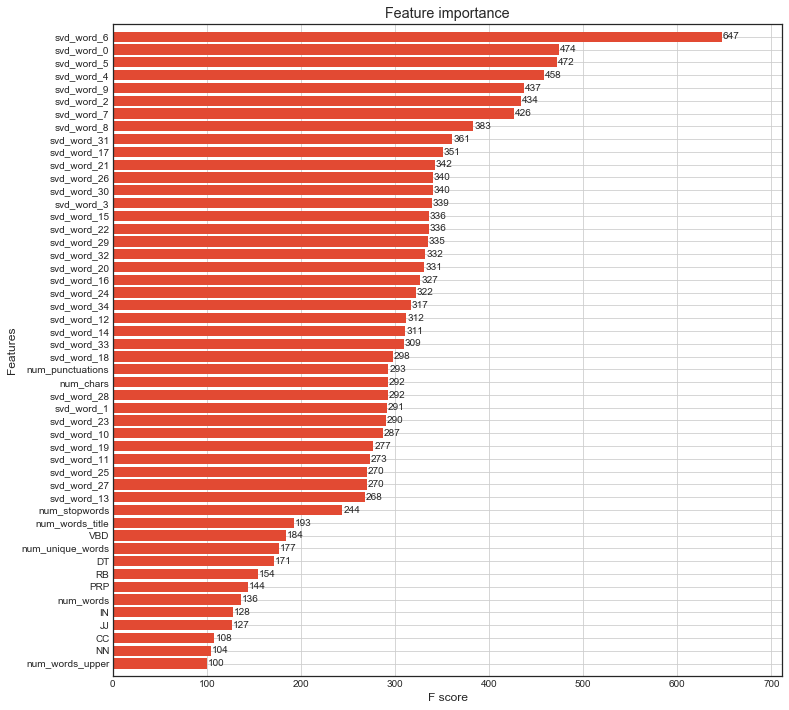

In [76]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Stacked Generalization 



In [77]:

train_stacked=train_svd_gram.copy()
test_stacked=test_svd_gram.copy()
stacked_data = train_svd_gram.append(test_svd_gram, ignore_index=True)
#frames = [train_svd_gram, test_svd_gram]
stacked_data.head()
stacked_data.shape

(27971, 53)

### SVM on data

In [78]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSVM(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_stacked["svm_eap"] = pred_train[:,0]
train_stacked["svm_hpl"] = pred_train[:,1]
train_stacked["svm_mws"] = pred_train[:,2]
test_stacked["svm_eap"] = pred_full_test[:,0]
test_stacked["svm_hpl"] = pred_full_test[:,1]
test_stacked["svm_mws"] = pred_full_test[:,2]

Mean cv score :  0.664578990898


In [80]:
assert train_stacked.shape == (19579, 56)
assert test_stacked.shape == (8392, 56)

In [81]:
# model evaluation using XGBost
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_stacked.loc[dev_index], train_stacked.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_stacked, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:0.936233	test-mlogloss:0.939957
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.404014	test-mlogloss:0.465718
[40]	train-mlogloss:0.335388	test-mlogloss:0.45035
[60]	train-mlogloss:0.287965	test-mlogloss:0.447602
[80]	train-mlogloss:0.251588	test-mlogloss:0.44789
[100]	train-mlogloss:0.221994	test-mlogloss:0.449018
[120]	train-mlogloss:0.194744	test-mlogloss:0.450659
Stopping. Best iteration:
[77]	train-mlogloss:0.256218	test-mlogloss:0.447386

cv scores :  [0.44738596222126836]


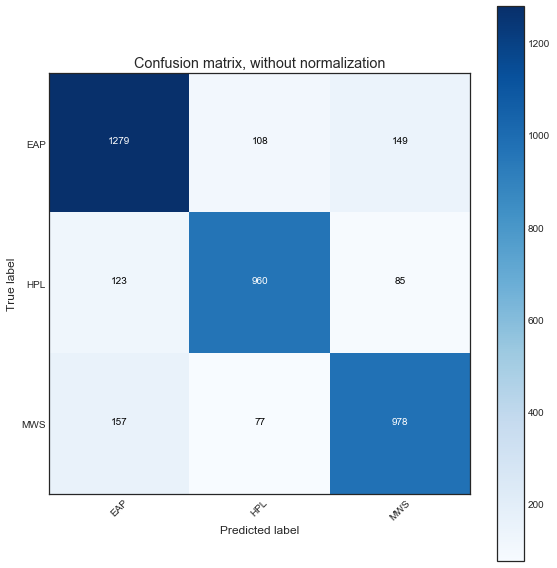

In [82]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

## uncleaned count vector with NVB

In [90]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf_uncleaned_count[dev_index], full_tfidf_uncleaned_count[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf_uncleaned_count)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_stacked["nvb_eap"] = pred_train[:,0]
train_stacked["nvb_hpl"] = pred_train[:,1]
train_stacked["nvb_mws"] = pred_train[:,2]
test_stacked["nvb_eap"] = pred_full_test[:,0]
test_stacked["nvb_hpl"] = pred_full_test[:,1]
test_stacked["nvb_mws"] = pred_full_test[:,2]

Mean cv score :  0.454118122959


In [84]:
assert train_stacked.shape == (19579, 59)
assert test_stacked.shape == (8392, 59)

In [103]:
# model evaluation using XGBost
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_stacked.loc[dev_index], train_stacked.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_stacked, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:0.930051	test-mlogloss:0.929892
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.393002	test-mlogloss:0.400085
[40]	train-mlogloss:0.363008	test-mlogloss:0.379487
[60]	train-mlogloss:0.347074	test-mlogloss:0.372081
[80]	train-mlogloss:0.335224	test-mlogloss:0.368545
[100]	train-mlogloss:0.325635	test-mlogloss:0.36608
[120]	train-mlogloss:0.317576	test-mlogloss:0.364574
[140]	train-mlogloss:0.310545	test-mlogloss:0.36413
[160]	train-mlogloss:0.304074	test-mlogloss:0.363507
[180]	train-mlogloss:0.297995	test-mlogloss:0.36238
[200]	train-mlogloss:0.292291	test-mlogloss:0.361735
[220]	train-mlogloss:0.286866	test-mlogloss:0.361603
[240]	train-mlogloss:0.281787	test-mlogloss:0.361751
[260]	train-mlogloss:0.276799	test-mlogloss:0.361503
Stopping. Best iteration:
[228]	train-mlogloss:0.284833	test-mlogloss:0.360971

[0]	train-mlogloss:0.929692	test-mlo

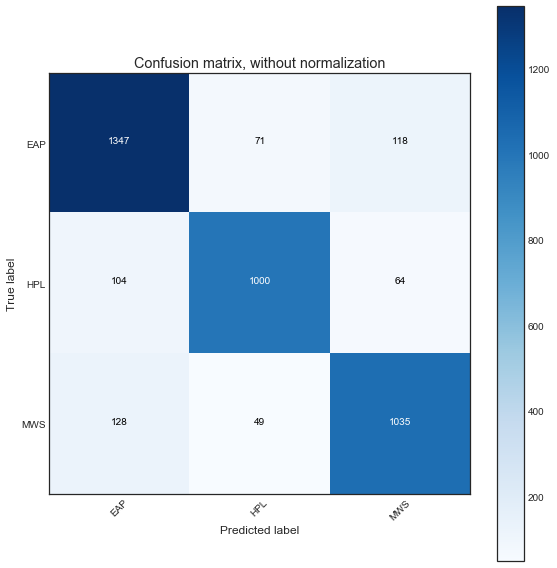

In [102]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

## Character TFIDF

In [134]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf_char = tfidf_vec.fit_transform(full_tfidf_df['cleaned_data'].values.tolist())
train_tfidf_char = tfidf_vec.transform(train_tfidf_df['cleaned_data'].values.tolist())
test_tfidf_char = tfidf_vec.transform(test_tfidf_df['cleaned_data'].values.tolist())
print('full_tfidf_char',full_tfidf_char.shape,'train_tfidf_char',train_tfidf_char.shape,'test_tfidf_char',test_tfidf_char.shape)

full_tfidf_char (27971, 170453) train_tfidf_char (19579, 170453) test_tfidf_char (8392, 170453)


In [135]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf_char[dev_index], train_tfidf_char[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSVM(dev_X, dev_y, val_X, val_y, test_tfidf_char)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.71658704939


In [136]:
train_stacked["svm_tfidf_char_eap"] = pred_train[:,0]
train_stacked["svm_tfidf_char_hpl"] = pred_train[:,1]
train_stacked["svm_tfidf_char_mws"] = pred_train[:,2]
test_stacked["svm_tfidf_char_eap"] = pred_full_test[:,0]
test_stacked["svm_tfidf_char_hpl"] = pred_full_test[:,1]
test_stacked["svm_tfidf_char_mws"] = pred_full_test[:,2]

In [137]:
train_stacked.columns

Index(['svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3', 'svd_word_4',
       'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8', 'svd_word_9',
       'svd_word_10', 'svd_word_11', 'svd_word_12', 'svd_word_13',
       'svd_word_14', 'svd_word_15', 'svd_word_16', 'svd_word_17',
       'svd_word_18', 'svd_word_19', 'svd_word_20', 'svd_word_21',
       'svd_word_22', 'svd_word_23', 'svd_word_24', 'svd_word_25',
       'svd_word_26', 'svd_word_27', 'svd_word_28', 'svd_word_29',
       'svd_word_30', 'svd_word_31', 'svd_word_32', 'svd_word_33',
       'svd_word_34', 'NN', 'IN', 'DT', 'JJ', 'VBD', 'PRP', 'RB', 'CC', 'VBP',
       'TO', 'WRB', 'num_words', 'num_unique_words', 'num_chars',
       'num_stopwords', 'num_punctuations', 'num_words_upper',
       'num_words_title', 'svm_eap', 'svm_hpl', 'svm_mws', 'nvb_eap',
       'nvb_hpl', 'nvb_mws', 'svm_tfidf_char_eap', 'svm_tfidf_char_hpl',
       'svm_tfidf_char_mws'],
      dtype='object')

In [142]:
# model evaluation using XGBost
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_stacked.loc[dev_index], train_stacked.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_stacked, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:0.930288	test-mlogloss:0.932069
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.374023	test-mlogloss:0.389123
[40]	train-mlogloss:0.334892	test-mlogloss:0.369782
[60]	train-mlogloss:0.312772	test-mlogloss:0.366153
[80]	train-mlogloss:0.294695	test-mlogloss:0.36372
[100]	train-mlogloss:0.280055	test-mlogloss:0.362728
[120]	train-mlogloss:0.267447	test-mlogloss:0.362607
[140]	train-mlogloss:0.255431	test-mlogloss:0.360841
[160]	train-mlogloss:0.244544	test-mlogloss:0.361106
[180]	train-mlogloss:0.234194	test-mlogloss:0.36208
[200]	train-mlogloss:0.224388	test-mlogloss:0.363404
Stopping. Best iteration:
[155]	train-mlogloss:0.247099	test-mlogloss:0.360476

cv scores :  [0.36047622698172171]


In [145]:
tfidf_ct = CountVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf_char_ct = tfidf_ct.fit_transform(full_tfidf_uncleaned_df['uncleaned_data'].values.tolist())
train_tfidf_char_ct = tfidf_ct.transform(train_tfidf_uncleaned_df['uncleaned_data'].values.tolist())
test_tfidf_char_ct = tfidf_ct.transform(test_tfidf_uncleaned_df['uncleaned_data'].values.tolist())
#print('full_tfidf_char',full_tfidf_char_ct.shape,'train_tfidf_char',train_tfidf_char_ct.shape,'test_tfidf_char',test_tfidf_char_ct.shape)


In [146]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf_char_ct[dev_index], train_tfidf_char_ct[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSVM(dev_X, dev_y, val_X, val_y, test_tfidf_char_ct)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  4.33531615706


In [147]:
train_stacked["svm_char_tfidf_char_eap"] = pred_train[:,0]
train_stacked["svm_char_tfidf_char_hpl"] = pred_train[:,1]
train_stacked["svm_char_tfidf_char_mws"] = pred_train[:,2]
test_stacked["svm_char_tfidf_char_eap"] = pred_full_test[:,0]
test_stacked["svm_char_tfidf_char_hpl"] = pred_full_test[:,1]
test_stacked["svm_char_tfidf_char_mws"] = pred_full_test[:,2]

In [270]:
# model evaluation using XGBost
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_stacked.loc[dev_index], train_stacked.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_stacked, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:0.920633	test-mlogloss:0.919775
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.360998	test-mlogloss:0.367644
[40]	train-mlogloss:0.323924	test-mlogloss:0.349088
[60]	train-mlogloss:0.302153	test-mlogloss:0.344264
[80]	train-mlogloss:0.285011	test-mlogloss:0.3415
[100]	train-mlogloss:0.270068	test-mlogloss:0.340061
[120]	train-mlogloss:0.257805	test-mlogloss:0.342098
[140]	train-mlogloss:0.246507	test-mlogloss:0.341813
Stopping. Best iteration:
[101]	train-mlogloss:0.269416	test-mlogloss:0.339959

cv scores :  [0.33995928522534574]


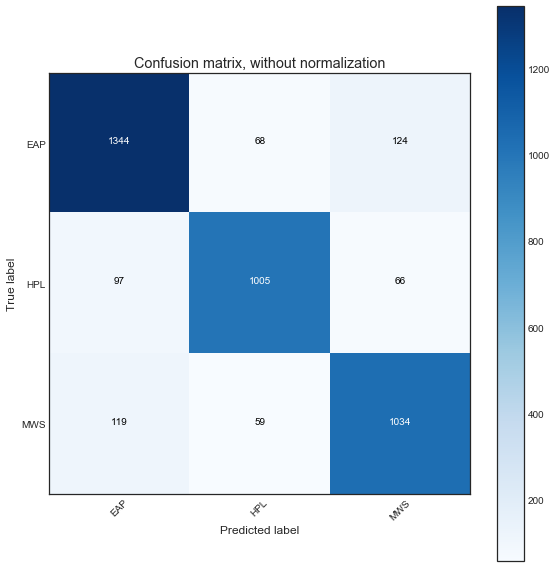

In [157]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()


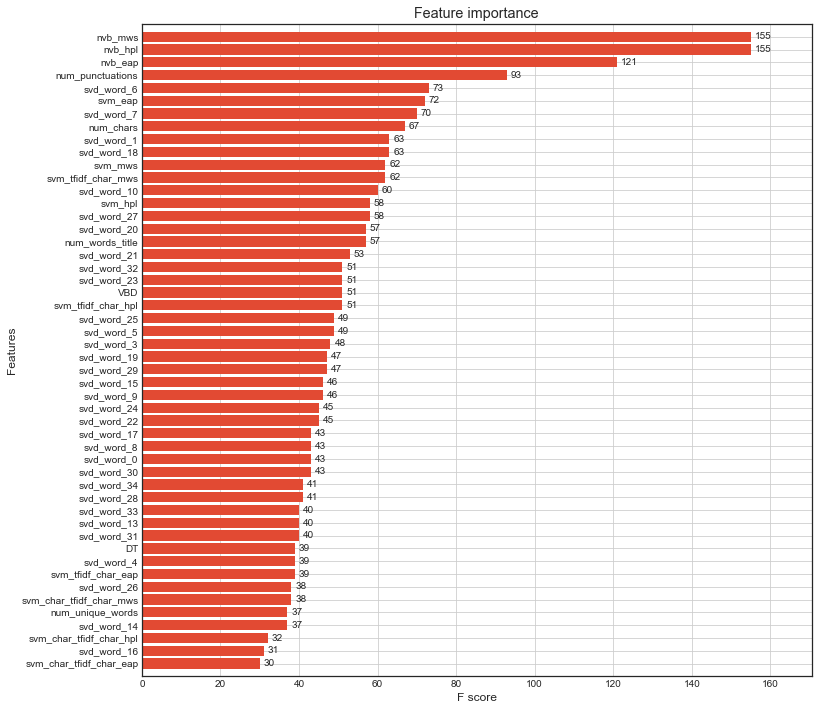

In [158]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
# Deep net

In [381]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

In [417]:

model=Sequential()
model.add(Dense(65, activation='relu', kernel_initializer='glorot_uniform', input_dim=65))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [418]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy')

In [419]:
from sklearn.preprocessing import label_binarize
categorical_labels = label_binarize(train['author'], classes=['EAP', 'HPL', 'MWS'])

In [420]:
from keras.utils.np_utils import to_categorical

categorical_labels = to_categorical(train_y, num_classes=3)
categorical_labels=pd.get_dummies(train_y)
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
#pred_train = np.zeros([train.shape[0], 3])
dev_index, val_index in kf.split(train_X)
dev_X, val_X = train_stacked.loc[dev_index], train_stacked.loc[val_index]
dev_y, val_y = categorical_labels.loc[dev_index], categorical_labels.loc[val_index]
#model.fit(dev_X,dev_y,batch_size=32,epochs=5)
#model.predict(inputs)
#pred_val_y, pred_test_y, model = deep(dev_X, dev_y, val_X, val_y, test_stacked,model)
model.fit(train_stacked, categorical_labels, validation_split=0.3,batch_size=32,epochs=200, verbose=1)




Train on 13705 samples, validate on 5874 samples
Epoch 1/200
13705/13705 [==============================] - 5s 359us/step - loss: 1.0825 - val_loss: 1.0613
Epoch 2/200
13705/13705 [==============================] - 3s 220us/step - loss: 1.0587 - val_loss: 1.0202
Epoch 3/200
13705/13705 [==============================] - 3s 218us/step - loss: 1.0192 - val_loss: 0.9370
Epoch 4/200
13705/13705 [==============================] - 3s 224us/step - loss: 0.9375 - val_loss: 0.7946
Epoch 5/200
13705/13705 [==============================] - 3s 244us/step - loss: 0.8280 - val_loss: 0.6825
Epoch 6/200
13705/13705 [==============================] - 3s 246us/step - loss: 0.7410 - val_loss: 0.5937
Epoch 7/200
13705/13705 [==============================] - 3s 247us/step - loss: 0.6603 - val_loss: 0.4969
Epoch 8/200
13705/13705 [==============================] - 3s 239us/step - loss: 0.5722 - val_loss: 0.4345
Epoch 9/200
13705/13705 [==============================] - 3s 218us/step - loss: 0.5239 - val_l

13705/13705 [==============================] - 3s 223us/step - loss: 0.3912 - val_loss: 0.3733
Epoch 77/200
13705/13705 [==============================] - 3s 220us/step - loss: 0.3907 - val_loss: 0.3729
Epoch 78/200
13705/13705 [==============================] - 3s 223us/step - loss: 0.3851 - val_loss: 0.3732
Epoch 79/200
13705/13705 [==============================] - 3s 217us/step - loss: 0.3888 - val_loss: 0.3732
Epoch 80/200
13705/13705 [==============================] - 3s 214us/step - loss: 0.3889 - val_loss: 0.3722
Epoch 81/200
13705/13705 [==============================] - 3s 225us/step - loss: 0.3907 - val_loss: 0.3722
Epoch 82/200
13705/13705 [==============================] - 3s 224us/step - loss: 0.3873 - val_loss: 0.3722
Epoch 83/200
13705/13705 [==============================] - 3s 221us/step - loss: 0.3891 - val_loss: 0.3720
Epoch 84/200
13705/13705 [==============================] - 3s 219us/step - loss: 0.3874 - val_loss: 0.3723
Epoch 85/200
13705/13705 [===============

13705/13705 [==============================] - 3s 224us/step - loss: 0.3664 - val_loss: 0.3693
Epoch 152/200
13705/13705 [==============================] - 3s 215us/step - loss: 0.3703 - val_loss: 0.3691
Epoch 153/200
13705/13705 [==============================] - 3s 217us/step - loss: 0.3649 - val_loss: 0.3701
Epoch 154/200
13705/13705 [==============================] - 3s 220us/step - loss: 0.3638 - val_loss: 0.3692
Epoch 155/200
13705/13705 [==============================] - 3s 224us/step - loss: 0.3629 - val_loss: 0.3694
Epoch 156/200
13705/13705 [==============================] - 3s 215us/step - loss: 0.3639 - val_loss: 0.3697
Epoch 157/200
13705/13705 [==============================] - 3s 223us/step - loss: 0.3630 - val_loss: 0.3694
Epoch 158/200
13705/13705 [==============================] - 3s 221us/step - loss: 0.3671 - val_loss: 0.3689
Epoch 159/200
13705/13705 [==============================] - 3s 221us/step - loss: 0.3640 - val_loss: 0.3687
Epoch 160/200
13705/13705 [======

In [405]:

pred_full_test = 0

pred_val_y = model.predict_proba(val_X)
pred_test_y = model.predict_proba(test_stacked)
pred_full_test = pred_full_test + pred_test_y
pred_train[val_index,:] = pred_val_y
cv_scores.append(metrics.log_loss(val_y, pred_val_y))

    #break
print("cv scores : ", cv_scores)




cv scores :  [0.33177534540579562]


In [406]:
#categorical_labels = to_categorical(train_y, num_classes=3)
#categorical_labels=pd.get_dummies(train_y)
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe1.csv", index=False)


In [271]:
pred_val_y

array([[ 1.  ,  0.  ,  0.  ],
       [ 0.92,  0.07,  0.01],
       [ 0.05,  0.92,  0.02],
       ..., 
       [ 0.13,  0.24,  0.63],
       [ 0.05,  0.86,  0.08],
       [ 0.99,  0.01,  0.  ]], dtype=float32)

In [272]:
val_y

0        0
4        1
13       1
20       0
21       1
32       2
42       1
46       2
53       2
60       2
66       2
87       2
89       2
94       2
98       0
104      1
108      2
111      1
114      0
121      0
137      0
141      1
158      2
171      1
182      2
190      2
193      2
205      1
208      1
219      2
        ..
19414    2
19420    0
19423    1
19426    2
19430    0
19431    2
19441    0
19442    1
19446    2
19447    1
19452    0
19453    1
19466    2
19467    1
19469    0
19474    0
19482    2
19490    1
19495    0
19498    2
19500    2
19513    0
19517    1
19521    1
19524    0
19531    0
19543    2
19550    0
19554    1
19576    0
Name: author, Length: 3916, dtype: int64

In [299]:
pred_val_y

array([[ 1.  ,  0.  ,  0.  ],
       [ 0.92,  0.07,  0.01],
       [ 0.05,  0.92,  0.02],
       ..., 
       [ 0.13,  0.24,  0.63],
       [ 0.05,  0.86,  0.08],
       [ 0.99,  0.01,  0.  ]], dtype=float32)

In [300]:
val_y

array([[ 0.01,  0.01,  0.01, ...,  0.02,  0.02,  0.02],
       [ 0.01,  0.01,  0.01, ...,  0.02,  0.02,  0.02],
       [ 0.01,  0.01,  0.01, ...,  0.02,  0.02,  0.02],
       ..., 
       [ 0.01,  0.01,  0.01, ...,  0.02,  0.02,  0.02],
       [ 0.01,  0.01,  0.01, ...,  0.02,  0.02,  0.02],
       [ 0.01,  0.01,  0.01, ...,  0.02,  0.02,  0.02]], dtype=float32)

In [107]:
# add the predictions as new features #
new_train["nb_cvec_eap"] = pred_train[:,0]
new_train["nb_cvec_hpl"] = pred_train[:,1]
new_train["nb_cvec_mws"] = pred_train[:,2]
new_test["nb_cvec_eap"] = pred_full_test[:,0]
new_test["nb_cvec_hpl"] = pred_full_test[:,1]
new_test["nb_cvec_mws"] = pred_full_test[:,2]

In [108]:
new_train.head()

,id,text,author,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,...,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,nb_cvec_eap,nb_cvec_hpl,nb_cvec_mws
0,id26305,"This process, however, afforded me no means of...",EAP,0.108977,-0.009414,-0.021025,-0.016956,-0.000202,0.008338,-0.005968,...,-0.007568,0.002837,0.009885,-0.006054,0.002556,-0.083092,0.010446,9.999716e-01,6.563561e-06,2.182729e-05
1,id17569,It never once occurred to me that the fumbling...,HPL,0.076259,-0.029311,0.015854,-0.002308,-0.019742,-0.040691,-0.011846,...,-0.055396,-0.104959,0.120075,0.009081,0.043842,-0.115891,0.045276,9.138307e-01,6.950595e-02,1.666334e-02
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0.062190,0.016412,-0.032900,-0.008599,0.010216,0.011195,0.001282,...,0.000046,0.012704,-0.007679,-0.019460,-0.020280,-0.035983,-0.018168,9.999977e-01,2.280931e-06,1.033326e-08
3,id27763,How lovely is spring As we looked from Windsor...,MWS,0.091601,0.007153,-0.040872,0.010401,-0.021434,-0.046862,-0.073782,...,-0.032799,0.030858,-0.033946,-0.053595,-0.106089,0.076740,0.141252,5.533091e-11,6.945369e-10,1.000000e+00
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,0.086179,-0.024638,-0.012520,-0.012379,0.019062,0.006739,0.004569,...,0.070404,0.073731,0.094575,0.008095,-0.041345,0.096191,0.117420,9.881167e-01,8.429793e-03,3.453497e-03


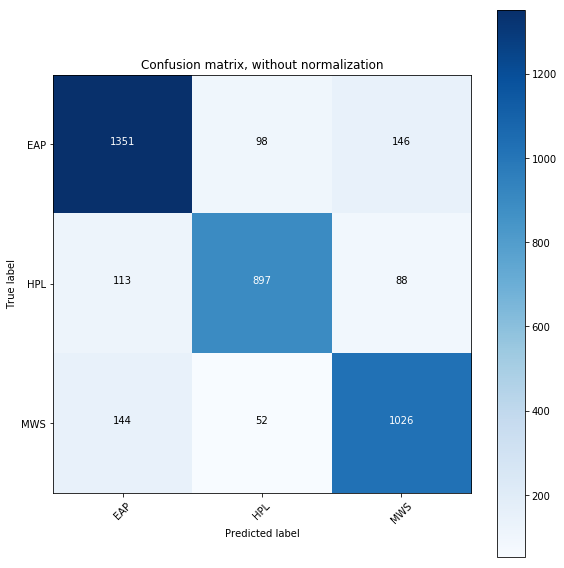

In [109]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

In [110]:
v =CountVectorizer(ngram_range=(1,7), analyzer='char')
full_data_tfidf = v.fit_transform(full_data['cleaned_string'].values.tolist())
train_data_tfidf=v.transform(train_data['cleaned_string'].values.tolist())
test_data_tfidf=v.transform(test_data['cleaned_string'].values.tolist())
print('full_tfidf',full_data_tfidf.shape,'train_tfidf',train_data_tfidf.shape,'test+tfidf',test_data_tfidf.shape)


full_tfidf (27971, 1206056) train_tfidf (19579, 1206056) test+tfidf (8392, 1206056)


In [111]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_data_tfidf[dev_index], train_data_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_data_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  4.14069621406


In [112]:
# add the predictions as new features #
new_train["nb_cvec_char_eap"] = pred_train[:,0]
new_train["nb_cvec_char_hpl"] = pred_train[:,1]
new_train["nb_cvec_char_mws"] = pred_train[:,2]
new_test["nb_cvec_char_eap"] = pred_full_test[:,0]
new_test["nb_cvec_char_hpl"] = pred_full_test[:,1]
new_test["nb_cvec_char_mws"] = pred_full_test[:,2]


In [113]:
v =TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_data_tfidf = v.fit_transform(full_data['cleaned_string'].values.tolist())
train_data_tfidf=v.transform(train_data['cleaned_string'].values.tolist())
test_data_tfidf=v.transform(test_data['cleaned_string'].values.tolist())
print('full_tfidf',full_data_tfidf.shape,'train_tfidf',train_data_tfidf.shape,'test+tfidf',test_data_tfidf.shape)


full_tfidf (27971, 170595) train_tfidf (19579, 170595) test+tfidf (8392, 170595)


In [114]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_data_tfidf[dev_index], train_data_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_data_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.721720011786


In [115]:
new_train["nb_tfidf_char_eap"] = pred_train[:,0]
new_train["nb_tfidf_char_hpl"] = pred_train[:,1]
new_train["nb_tfidf_char_mws"] = pred_train[:,2]
new_test["nb_tfidf_char_eap"] = pred_full_test[:,0]
new_test["nb_tfidf_char_hpl"] = pred_full_test[:,1]
new_test["nb_tfidf_char_mws"] = pred_full_test[:,2]

## XG bost

In [215]:

cols_to_drop = ['id', 'text']
trainX = new_train.drop(cols_to_drop+['author'], axis=1)
testX= new_test.drop(cols_to_drop, axis=1)
print(trainX.shape)
print('='*90)
print(testX.shape)

(19579, 29)
(8392, 29)


In [216]:
test_data.reset_index(drop=True, inplace=True)
testX.reset_index(drop=True, inplace=True)
train_X = pd.concat([train_data.iloc[:,2:8],trainX], axis=1)
test_X =  pd.concat([test_data.iloc[:,2:8],testX], axis=1)
print(train_X.shape)
print('='*90)
print(test_X.shape)

(19579, 35)
(8392, 35)


In [217]:
test_X

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,svd_word_0,svd_word_1,svd_word_2,svd_word_3,...,svd_word_19,nb_cvec_eap,nb_cvec_hpl,nb_cvec_mws,nb_cvec_char_eap,nb_cvec_char_hpl,nb_cvec_char_mws,nb_tfidf_char_eap,nb_tfidf_char_hpl,nb_tfidf_char_mws
0,19,19,110,9,3,1,0.070506,-0.024569,-0.013469,1.379200e-02,...,-0.061568,1.335811e-03,9.264423e-05,9.985715e-01,4.327525e-39,8.204313e-45,1.000000e+00,0.239608,0.031995,0.728397
1,62,49,330,33,7,1,0.070943,-0.037304,0.015752,-4.833088e-02,...,0.003667,9.989629e-01,1.525893e-04,8.845107e-04,1.000000e+00,6.318275e-66,4.149786e-37,0.862848,0.032329,0.104823
2,33,30,189,15,3,0,0.059881,0.033598,-0.020172,-1.557542e-02,...,0.002217,2.219055e-02,9.778018e-01,7.701595e-06,6.241907e-05,9.999376e-01,2.058595e-74,0.717503,0.265926,0.016572
3,41,34,223,19,5,2,0.084152,0.086556,0.059672,-1.823239e-02,...,-0.018596,7.819387e-01,2.180613e-01,6.687137e-09,6.608694e-02,9.339131e-01,6.906811e-80,0.711324,0.264295,0.024381
4,11,11,53,6,1,1,0.048417,-0.015857,-0.001067,2.053782e-02,...,-0.023402,9.690272e-01,1.588511e-02,1.508771e-02,1.000000e+00,1.223688e-20,3.746035e-11,0.865177,0.046461,0.088362
5,32,28,202,14,8,0,0.050744,-0.001894,-0.017876,-1.195571e-02,...,0.009227,8.059516e-01,1.939894e-01,5.897297e-05,1.000000e+00,4.218552e-39,1.358532e-40,0.917683,0.027620,0.054697
6,13,11,68,9,2,0,0.062590,-0.004125,0.023097,1.740811e-02,...,-0.016385,5.973127e-01,3.901581e-01,1.252919e-02,8.517559e-02,9.148244e-01,3.154756e-13,0.558269,0.354615,0.087115
7,30,23,155,17,3,5,0.122935,0.085521,0.115573,-4.694114e-03,...,0.008557,4.152804e-03,3.147029e-02,9.643769e-01,1.533023e-28,5.253267e-11,1.000000e+00,0.378435,0.184325,0.437240
8,28,22,172,14,5,0,0.100690,0.053944,-0.097083,-1.828322e-02,...,0.014664,9.999611e-01,3.885789e-05,2.050872e-08,1.000000e+00,2.338662e-66,1.774546e-106,0.986834,0.007561,0.005605
9,8,8,42,2,2,0,0.098335,0.176801,0.166211,1.619368e-02,...,0.004312,7.876407e-01,9.304880e-03,2.030544e-01,1.000000e+00,3.619861e-13,2.581030e-12,0.779934,0.110008,0.110058


In [218]:
train_X.head

<bound method NDFrame.head of        num_words  num_unique_words  num_chars  num_stopwords  \
0             41                35        231             19   
1             14                14         71              8   
2             36                32        200             16   
3             34                32        206             13   
4             27                25        174             11   
5             83                66        468             43   
6             21                21        128              9   
7              8                 8         43              4   
8             88                62        488             45   
9             23                18        144             11   
10            22                19        107             12   
11            10                10         63              5   
12            15                14         87              6   
13            15                15         86              5   
14        

In [219]:
test_id = new_test['id'].values

In [220]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [96]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

NameError: name 'test_X' is not defined

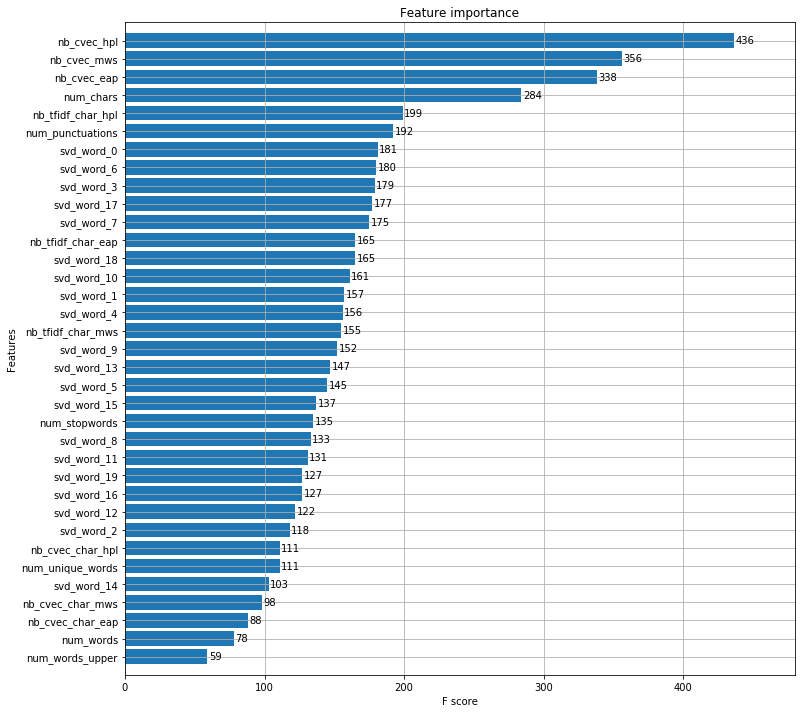

In [222]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

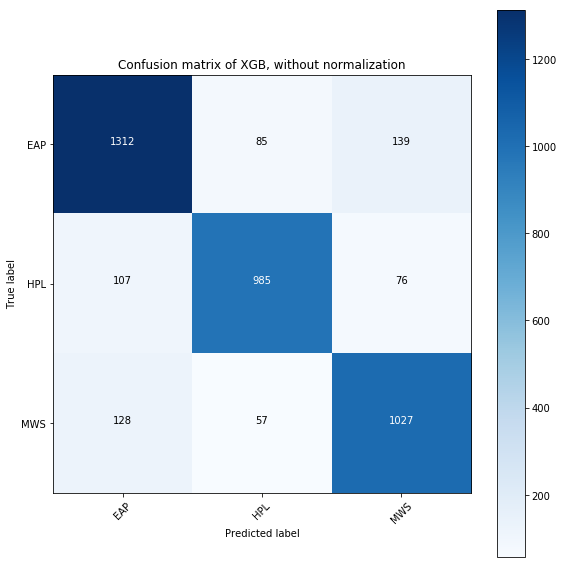

In [223]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

In [167]:
pred_full_test.shape

(16784, 3)

In [168]:
pred_val_y.shape

(3916, 3)

In [170]:
train_X.shape

(19579, 35)

## adding gramer data


In [360]:
grammer_df_train=grammer_df[:19579]
grammer_df_test=grammer_df[19579:]
print(grammer_df_train.shape)
print(grammer_df_test.shape)



(19579, 37)
(16784, 37)


In [367]:
train_XG = pd.concat([trainX,grammer_df_train], axis=1)
test_XG =  pd.concat([testX,grammer_df_test], axis=1)
print(train_X.shape)
print('='*90)
print(test_X.shape)
print('='*90)
print(test_XG.shape)
print('='*90)
print(test_XG.shape)

(19579, 35)
(8392, 35)
(16784, 37)
(16784, 37)


In [368]:
print(trainX.columns)
print(train_XG.columns)

Index(['svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3', 'svd_word_4',
       'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8', 'svd_word_9',
       'svd_word_10', 'svd_word_11', 'svd_word_12', 'svd_word_13',
       'svd_word_14', 'svd_word_15', 'svd_word_16', 'svd_word_17',
       'svd_word_18', 'svd_word_19', 'nb_cvec_eap', 'nb_cvec_hpl',
       'nb_cvec_mws', 'nb_cvec_char_eap', 'nb_cvec_char_hpl',
       'nb_cvec_char_mws', 'nb_tfidf_char_eap', 'nb_tfidf_char_hpl',
       'nb_tfidf_char_mws'],
      dtype='object')
Index(['svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3', 'svd_word_4',
       'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8', 'svd_word_9',
       'svd_word_10', 'svd_word_11', 'svd_word_12', 'svd_word_13',
       'svd_word_14', 'svd_word_15', 'svd_word_16', 'svd_word_17',
       'svd_word_18', 'svd_word_19', 'nb_cvec_eap', 'nb_cvec_hpl',
       'nb_cvec_mws', 'nb_cvec_char_eap', 'nb_cvec_char_hpl',
       'nb_cvec_char_mws', 'nb_tfidf_char_eap'

In [357]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_XG):
    dev_X, val_X = train_XG.loc[dev_index], train_XG.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00375	test-mlogloss:1.00352
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.453572	test-mlogloss:0.457541
[40]	train-mlogloss:0.389707	test-mlogloss:0.401296
[60]	train-mlogloss:0.367044	test-mlogloss:0.388949
[80]	train-mlogloss:0.352227	test-mlogloss:0.382671
[100]	train-mlogloss:0.341234	test-mlogloss:0.378997
[120]	train-mlogloss:0.332019	test-mlogloss:0.377783
[140]	train-mlogloss:0.324139	test-mlogloss:0.376737
[160]	train-mlogloss:0.31655	test-mlogloss:0.375881
[180]	train-mlogloss:0.309922	test-mlogloss:0.375017
[200]	train-mlogloss:0.303194	test-mlogloss:0.374065
[220]	train-mlogloss:0.297055	test-mlogloss:0.373323
[240]	train-mlogloss:0.291346	test-mlogloss:0.373646
[260]	train-mlogloss:0.286033	test-mlogloss:0.37389
Stopping. Best iteration:
[226]	train-mlogloss:0.295394	test-mlogloss:0.373135



ValueError: feature_names mismatch: ['NN', 'IN', 'DT', 'JJ', 'VBD', 'PRP', 'RB', 'CC', 'svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3', 'svd_word_4', 'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8', 'svd_word_9', 'svd_word_10', 'svd_word_11', 'svd_word_12', 'svd_word_13', 'svd_word_14', 'svd_word_15', 'svd_word_16', 'svd_word_17', 'svd_word_18', 'svd_word_19', 'nb_cvec_eap', 'nb_cvec_hpl', 'nb_cvec_mws', 'nb_cvec_char_eap', 'nb_cvec_char_hpl', 'nb_cvec_char_mws', 'nb_tfidf_char_eap', 'nb_tfidf_char_hpl', 'nb_tfidf_char_mws'] ['num_words', 'num_unique_words', 'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper', 'svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3', 'svd_word_4', 'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8', 'svd_word_9', 'svd_word_10', 'svd_word_11', 'svd_word_12', 'svd_word_13', 'svd_word_14', 'svd_word_15', 'svd_word_16', 'svd_word_17', 'svd_word_18', 'svd_word_19', 'nb_cvec_eap', 'nb_cvec_hpl', 'nb_cvec_mws', 'nb_cvec_char_eap', 'nb_cvec_char_hpl', 'nb_cvec_char_mws', 'nb_tfidf_char_eap', 'nb_tfidf_char_hpl', 'nb_tfidf_char_mws']
expected DT, RB, NN, VBD, CC, PRP, IN, JJ in input data
training data did not have the following fields: num_unique_words, num_stopwords, num_words_upper, num_punctuations, num_words, num_chars